# Diffusion Monte Carlo Method
## 1次元調和振動子の基底状態
- ハミルトニアン:
$$H = -\frac{\hbar^2}{2m}\frac{d^2}{dx^2} + \frac{1}{2}m\omega^2 x^2.$$

- Trial wavefunction:
$$\Psi_G(x) = e^{-\frac{\alpha}{2}x^2}$$
- 厳密解（$\hbar = m = \omega = 1$）:
\begin{align}
    \psi_0(x) &= \pi^{-1/4} e^{-x^2/2}, \\
    E_0 &= \frac{1}{2}.
\end{align}

パラメータ、`alpha, E_T_init`を調整して実行すると、概ね厳密解の0.5に近い値が推定される。



In [1]:
def plot_walkers_diffusion(plt, X_hist):
    """
    """
    # walkerの広がり具合をプロット
    x = np.concatenate([[i]*len(sub) for i, sub in enumerate(X_hist)])
    y = np.concatenate(X_hist)
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, s=0.1, alpha=0.7)
    plt.xlabel("step")
    plt.ylabel("x")
    plt.title("Distribution of Walkers")

def plot_walkers_population(plt, X_hist):
    # walkerのpopulationの変化をプロット
    populations = [len(sub) for sub in X_hist]
    plt.figure(figsize=(10, 6))
    plt.plot(populations)
    plt.title("Population of Walkers")
    plt.ylabel("Population")

def plot_walkers_distribution(plt, X_hist):
    # 波動関数の二乗の形をプロット
    # 座標の配列を全部1次元にまとめて、その分布をプロットする
    data = np.concatenate(X_hist)
    # --- (3) 理論波動関数 |ψ₀(x)|² の計算 ---
    x = np.linspace(-4, 4, 400)
    # TODO: 分布が一致していない。Ψ^2ではない？規格化していない？(walkerの方の分布)
    psi2 = (1 / np.sqrt(np.pi)) * np.exp(-x**2)
    # psi2 = (1 / np.pi**(1/4)) * np.exp(-0.5*x**2)
    
    # --- (2) ヒストグラムを確率密度として描画 ---
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=200, density=True, alpha=0.3, color='gray', label='Walkers (DMC)')
    plt.plot(x, psi2, 'b-', lw=1, label=r'$|\psi_0(x)|^2 = \pi^{-1/2} e^{-x^2}$')
    plt.xlabel('x')
    plt.ylabel('Probability density')
    plt.title('Walker distribution vs analytical |ψ₀(x)|²')
    plt.legend()
    plt.grid(True)

def plot_evolution_of_E(plt, E_arr):
    plt.figure(figsize=(10, 6))
    plt.plot(E_arr)
    plt.title("Energy evolution over steps")
    plt.ylabel("Energy E_0")
    plt.grid(True)
    
    
# def plot_DMC(E_est, E_arr, X_hist):
#     """
#     DMCの結果をプロットするヘルパー関数

#     Parameters
#     ----------
#     E_est : 推定基底エネルギー
#     E_arr : タイムステップごとに推定エネルギー
#     X_hist : タイムステップごとのwalkerの履歴
#     """
#     # figure と 3つのサブプロット（縦3段）を作成
#     fig, axes = plt.subplots(3, 1, figsize=(10, 12))  # (行, 列)
    
#     # walkerの広がり具合をプロット
#     x = np.concatenate([[i]*len(sub) for i, sub in enumerate(X_hist)])
#     y = np.concatenate(X_hist)
#     axes[0].scatter(x, y, s=0.1, alpha=0.7)
#     axes[0].set_xlabel("step")
#     axes[0].set_ylabel("x")
#     axes[0].set_title("Distribution of Walkers")
    
#     # walkerのpopulationの変化をプロット
#     populations = [len(sub) for sub in X_hist]
#     axes[1].plot(populations)
#     axes[1].set_title("Population of Walkers")
#     axes[0].set_ylabel("Population")
    
#     # 波動関数の二乗の形をプロット
#     # 座標の配列を全部1次元にまとめて、その分布をプロットする
#     data = np.concatenate(X_hist)
#     # --- (3) 理論波動関数 |ψ₀(x)|² の計算 ---
#     x = np.linspace(-4, 4, 400)
#     # TODO: 分布が一致していない。Ψ^2ではない？規格化していない？(walkerの方の分布)
#     psi2 = (1 / np.sqrt(np.pi)) * np.exp(-x**2)
#     # psi2 = (1 / np.pi**(1/4)) * np.exp(-0.5*x**2)
    
#     # --- (2) ヒストグラムを確率密度として描画 ---
#     axes[2].hist(data, bins=200, density=True, alpha=0.3, color='gray', label='Walkers (DMC)')
#     axes[2].plot(x, psi2, 'b-', lw=1, label=r'$|\psi_0(x)|^2 = \pi^{-1/2} e^{-x^2}$')
#     axes[2].set_xlabel('x')
#     axes[2].set_ylabel('Probability density')
#     axes[2].set_title('Walker distribution vs analytical |ψ₀(x)|²')
#     axes[2].legend()
#     axes[2].grid(True)
    
#     plt.tight_layout()
#     plt.show()

DMC estimate: E0 = 0.48556642 (exact = 0.5)


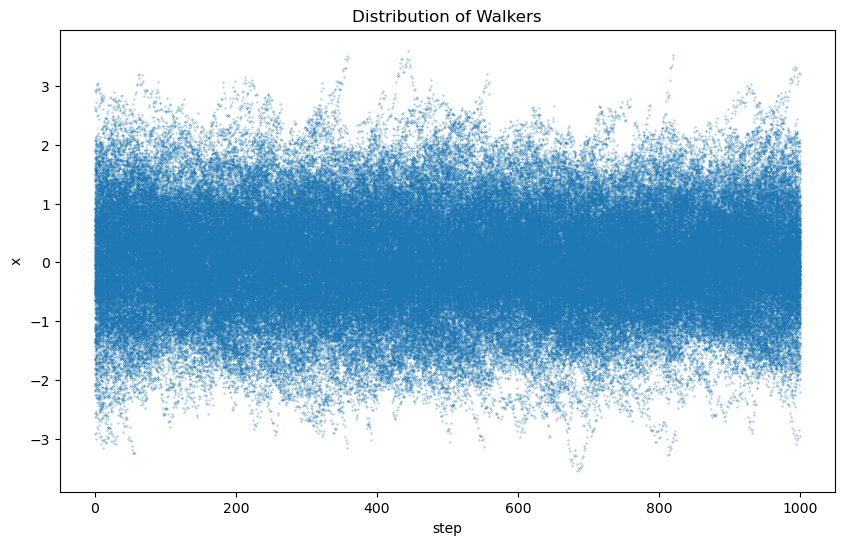

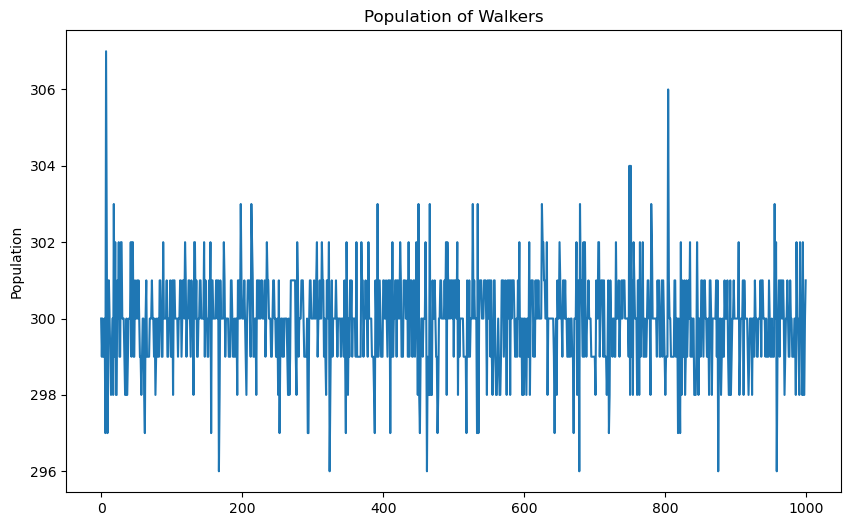

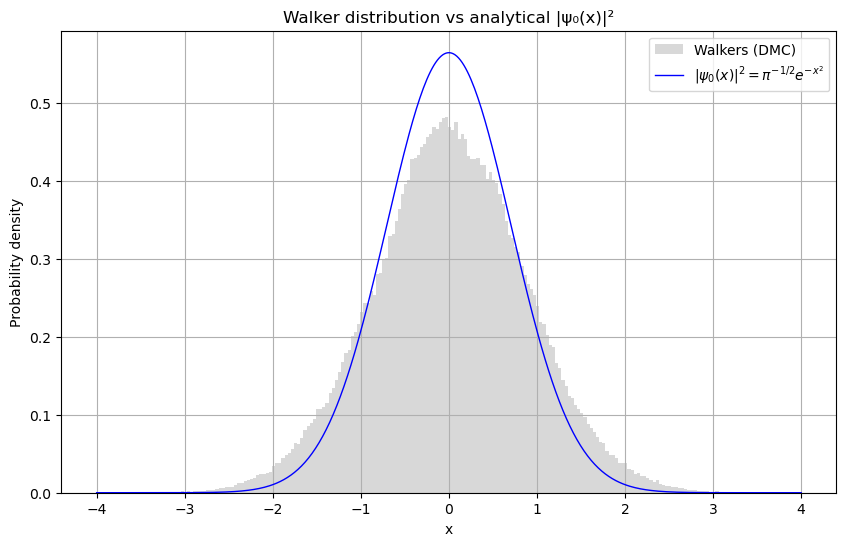

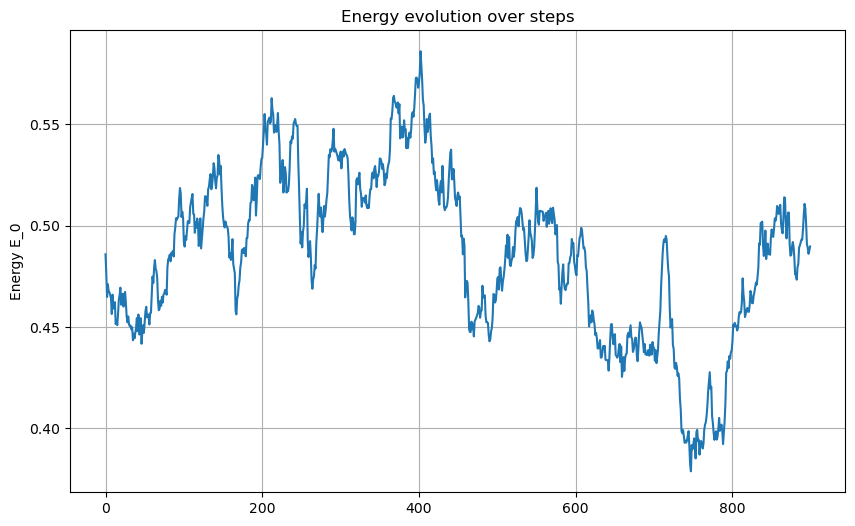

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def dmc_1d_harmonic(
    n_walkers=2000,
    n_steps=4000,
    dt=0.01,
    k=1.0, 
    burn_in=500,
    alpha=0.8,
    E_T_init = 0.4,
    seed=None,
):
    """
    Diffusion Monte Carlo for 1D harmonic oscillator ground state.
    H = -1/2 d^2/dx^2 + 1/2 x^2  (atomic units: ħ = m = ω = 1)

    Importance-sampled DMC with trial Psi_T(x) = exp(-alpha x^2 / 2).
    Local energy: E_L(x) = alpha/2 + (1 - alpha**2) * x**2 / 2
      -> alpha=1.0 なら E_L(x) ≡ 0.5（分散ゼロの理想ケース）

    Parameters
    ----------
    n_walkers : 初期ウォーカー数（目標個体数）
    n_steps   : 総ステップ数
    dt        : 時間刻み Δτ
    k         : Population controlのパラメータ
    burn_in   : 熱化のための前半ステップ数（推定から除外）
    alpha     : 試行関数パラメータ（=1.0 で厳密基底を再現） guiding function Psi_Gに含まれるパラメータで、本来はVMCによって得られる
    E_T_init  : 試行エネルギー populationを制御するための値で出来るだけ求めたい基底エネルギーに近い値をセットする
                0.5をセットすればよいが、すでに厳密値と一致しているため、あえて少しずらした値をデフォルト値にしている
    seed      : 乱数シード

    Returns
    -------
    E_mean    : 推定エネルギー（混合推定量）の平均
    E_sem     : 標準誤差（標本標準偏差/√サンプル数）
    history   : 各ステップの混合推定量（burn-in 以降）
    """
    rng = np.random.default_rng(seed)
    # LATER: テキストではVMCで得られた分布を使う
    # 初期分布は適当に広がった正規分布
    x = rng.normal(loc=0.0, scale=1.0, size=n_walkers).astype(np.float64)

    # LATER: 本来はVMCで求めたエネルギー期待値を入れる
    E_T = E_T_init

    # ローカルエネルギー（重要サンプリング系）
    # alpha=1.0にするとlocal energyが常に0.5を返すようになってしまう
    # E_L(x) = Psi_G^(-1) * H * Psi_G = alpha/2 + (1 - alpha^2) * x^2 / 2
    def local_energy(x):
        return 0.5 * alpha + 0.5 * (1.0 - alpha**2) * (x * x)

    # ドリフト（量子力） F = ∇ ln Psi_G^2 = -2 alpha x（1D）
    def F(x):
        return -2.0 * alpha * x

    E_samples = []
    x_hist = []

    for step in range(n_steps):
        x_hist.append(x)
        
        # ---- drifted diffusion proposal ----
        # x' = x + (dt/2) F(x) + χ, with χ ~ N(0, dt)
        x_prop = x + 0.5 * dt * F(x) + rng.normal(0.0, np.sqrt(dt), size=x.shape)

        # ローカルエネルギー（対称化のため x と x' の平均を使う）
        EL_x = local_energy(x)
        EL_p = local_energy(x_prop)

        # ---- branching weights ----
        w = np.exp(-dt * 0.5 * (EL_x + EL_p - 2*E_T))  # eq. 24.24
        m = np.floor(w + rng.random(w.size)).astype(int)

        # 子孫を生成
        survivors_mask = m > 0
        # if not np.any(survivors_mask):
        #     # 全滅回避：リセット（まれに起きる極端な揺らぎへの保険）
        #     x = rng.normal(0.0, 1.0, size=target_N)
        #     E_T = 0.5
        #     continue

        # m > 0となったx'のみを抜き出して、mの分複製する
        # ex.
        #   x_prop = [4, 7, 8, 10]
        #   m = [0, 2, 3, 0]
        #   => x_new = [7, 7, 8, 8, 8] 
        x_new = np.repeat(x_prop[survivors_mask], m[survivors_mask])

        # ---- population control (feedback procedure) ----
        N_new = x_new.size
        E_0 = local_energy(x_new).mean()
        E_T = E_0 - np.log(N_new/n_walkers)/(k*dt)

        # 人口が過度に膨張・縮小した場合、薄いリサンプリングで安定化
        # （個体値の統計は保ちやすい多重サンプリング方式）
        # if N_new > 4 * target_N:
        #     choose = rng.choice(N_new, size=2 * target_N, replace=False)
        #     x = x_new[choose]
        # elif N_new < target_N // 4:
        #     # 足りなければリサンプルで補充
        #     choose = rng.choice(N_new, size=target_N, replace=True)
        #     x = x_new[choose]
        # else:
        #     x = x_new
        x = x_new

        # ---- mixed estimator: エネルギー推定（burn-in後に記録）----
        if step >= burn_in:
            # 混合推定量は単純に E_L のウォーカー平均
            E_step = np.mean(local_energy(x))
            E_samples.append(E_step)

    if len(E_samples) == 0:
        # return np.nan, np.nan, np.array([])
        return np.nan

    # walker平均の平均がエネルギー推定値
    E_arr = np.array(E_samples)
    E_est = E_arr.mean()
    # 有効サンプル間の相関を無視した素朴な標準誤差（目安）
    # E_sem = E_arr.std(ddof=1) / np.sqrt(len(E_arr))
    # return E_mean, E_sem, E_arr
    return E_est, E_arr, x_hist

E_est, E_arr, x_hist = dmc_1d_harmonic(n_walkers=300, n_steps=1000, burn_in=100, alpha=0.3, E_T_init=0.3)
# print(f"DMC estimate: E0 = {E_est:.6f} ± {dE:.6f}  (exact = 0.5)")
print(f"DMC estimate: E0 = {E_est:.8f} (exact = 0.5)")

# plot_DMC(E_est, E_arr, x_hist)
plot_walkers_diffusion(plt, x_hist)
plot_walkers_population(plt, x_hist)
plot_walkers_distribution(plt, x_hist)
plot_evolution_of_E(plt, E_arr)
plt.show()

## 1次元調和振動子2粒子ボソン系（相互作用しない）
- ハミルトニアン $$H = \sum_{i=1}^{2} \left[ -\frac{1}{2} \frac{d^2}{dx_i^2} + \frac{1}{2}\omega^2 x_i^2 \right]$$
- 厳密解 $E_0=\hbar\omega$
- ChatGPTで生成した[ソースコード](https://chatgpt.com/share/68ee13a9-8ccc-800d-8f2e-d9ed0309b019)
- 結果 $E_0 = 1.013198 (exact = 1.0)$ で概ね正しく推定できている

DMC estimate: E0 = 1.027601 (exact = 1.0)


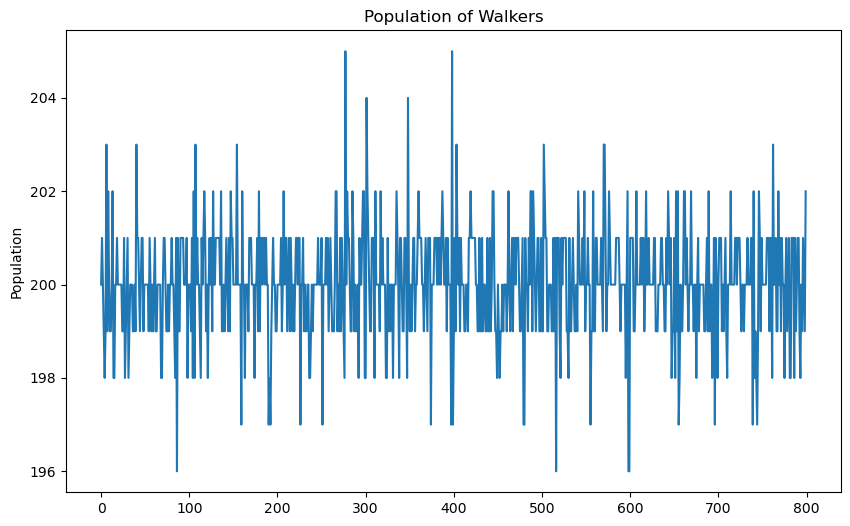

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def dmc_1d_2p_harmonic(
    n_walkers=2000,
    n_steps=4000,
    dt=0.01,
    k=1.0, 
    burn_in=500,
    alpha=0.8,
    E_T_init = 1.8,
    seed=None,
):
    rng = np.random.default_rng(seed)
    # 初期分布は適当に広がった正規分布
    X = rng.normal(loc=0.0, scale=1.0, size=(n_walkers, 2)).astype(np.float64)

    # trial energy
    E_T = E_T_init

    # E_L = Psi_G^{-1} * H * Psi_G
    # LATER: n粒子対応しておく
    def local_energy(X):
        return alpha + 0.5*(1.0 - alpha**2) * np.sum(X*X, axis=1)

    # ドリフト（量子力）
    # Fi = ∇_i ln Psi_G
    def F(X):
        return -2.0 * alpha * X

    E_samples = []
    X_hist = []

    for step in range(n_steps):
        X_hist.append(X)
        
        # ---- drifted diffusion proposal ----
        X_prop = X + 0.5 * dt * F(X) + rng.normal(0.0, np.sqrt(dt), size=X.shape)

        # ローカルエネルギー（対称化のため x と x' の平均を使う）
        EL = local_energy(X)
        EL_p = local_energy(X_prop)

        # ---- branching weights ----
        w = np.exp(-dt * 0.5 * (EL + EL_p - 2*E_T))
        m = np.floor(w + rng.random(w.size)).astype(int)

        # 子孫を生成
        survivors_mask = m > 0

        # m > 0となったx'のみを抜き出して、mの分複製する
        X_new = np.repeat(X_prop[survivors_mask], m[survivors_mask], axis=0)

        # ---- population control (feedback procedure) ----
        N_new = X_new.shape[0]
        E_0 = local_energy(X_new).mean()
        E_T = E_0 - np.log(N_new/n_walkers)/(k*dt)
        X = X_new

        # ---- mixed estimator: エネルギー推定（burn-in後に記録）----
        if step >= burn_in:
            # 混合推定量は単純に E_L のウォーカー平均
            E_step = np.mean(local_energy(X))
            E_samples.append(E_step)

    if len(E_samples) == 0:
        return np.nan, np.nap

    # walker平均の平均がエネルギー推定値
    E_arr = np.array(E_samples)
    E_est = E_arr.mean()
    return E_est, E_arr, X_hist

E_est, E_arr, X_hist = dmc_1d_2p_harmonic(n_walkers=200, n_steps=800, burn_in=200, alpha=0.3)
print(f"DMC estimate: E0 = {E_est:.6f} (exact = 1.0)")

plot_walkers_population(plt, X_hist)

## 1次元調和振動子2粒子フェルミオン系（相互作用しない, spinless）
- ハミルトニアン:
$$H = \sum_{i=1}^{2} \left[ -\frac{1}{2} \frac{d^2}{dx_i^2} + \frac{1}{2}\omega^2 x_i^2 \right]$$

- Trial wavefunction:
$$\Psi_G(x) = (x_2-x_1)e^{-\frac{\alpha}{2}(x_1^2+x_2^2)}$$


- Local energy:
$$
E_L=\Psi^{-1}_G\hat{H}\Psi_G= -\frac{1}{(x_2 - x_1)^2}
  + 2\alpha
  + \frac{1}{2}(1 - \alpha^2)(x_1^2 + x_2^2)
$$

- 厳密解
$$E_0=2\hbar\omega$$

負符号問題への対策を何もせず、エネルギー推定を符号付き重み平均で行っているため、$\Delta\tau=0.05$など大きめに取ると、頻繁に計算が破綻するようになる。

DMC estimate: E0 = 1.961415 (exact = 2.0)


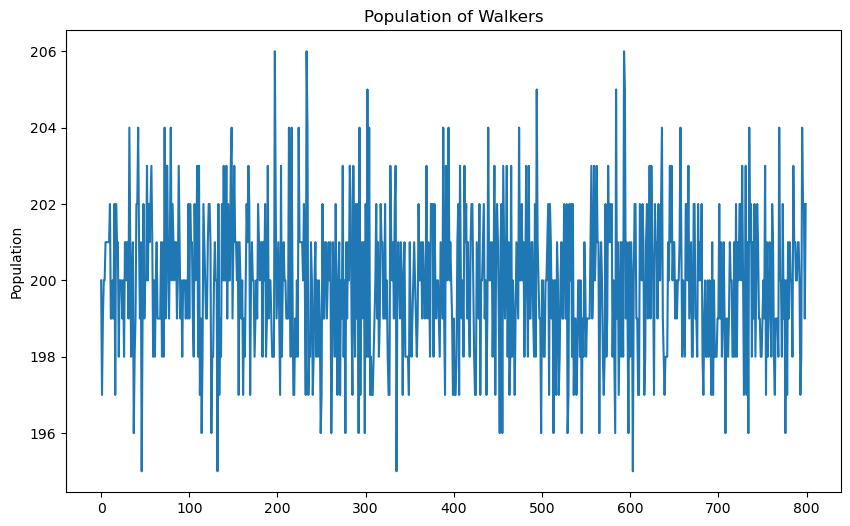

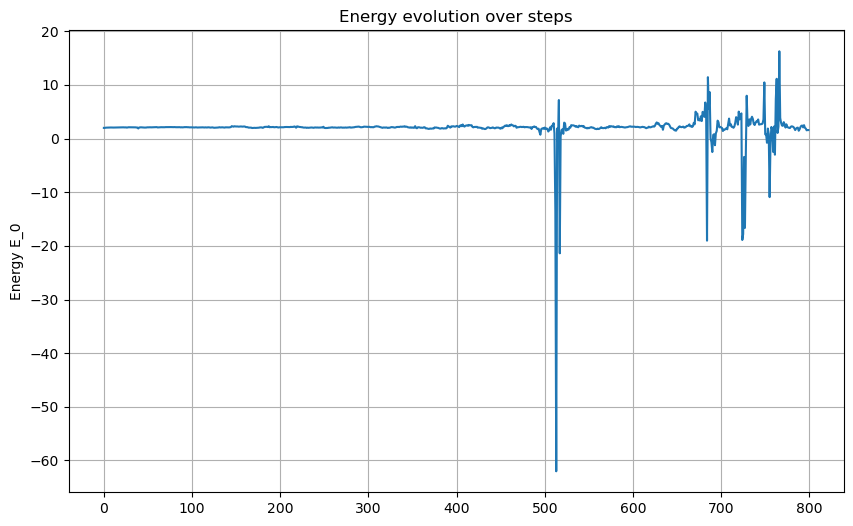

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def dmc_1d_2p_fermion_harmonic(
    n_walkers=2000,
    n_steps=4000,
    dt=0.01,
    k=1.0, 
    burn_in=500,
    alpha=0.8,
    w_cap=5,
    E_T_init = 1.8,
    seed=None,
):
    rng = np.random.default_rng(seed)
    # 初期分布は適当に広がった正規分布
    X = rng.normal(loc=0.0, scale=1.0, size=(n_walkers, 2)).astype(np.float64)
    signs = np.ones(n_walkers)
    weights = np.ones(n_walkers)

    # trial energy
    E_T = E_T_init

    # E_L = Psi_G^{-1} * H * Psi_G
    def local_energy(X):
        x1 = X[:,0]; x2 = X[:,1]
        delta = x2 - x1 
        # delta = np.where(delta==0.0, np.sign(delta)+1e-12, delta) # 0除算を避けるため微小値を足す
        return 2*alpha - 0.5*(alpha**2 - 1)*(x1**2 + x2**2)

    def sign_factor(X, Xp):
        x1 = X[:,0]; x2 = X[:,1]
        xp1 = Xp[:,0]; xp2 = Xp[:,1]
        return np.sign((xp2 - xp1)*(x2 - x1))
        
    # ドリフト（量子力）
    # Fi = ∇_i ln Psi_G
    # TODO: 解析的に式を導く
    def F(X):
        # return -2.0 * alpha * X
        x1 = X[:,0]; x2 = X[:,1]
        delta = x2 - x1
        # 0割り回避の超小イプシロン（物理は変えないが数値発散を少し和らげる）
        delta = np.where(delta==0.0, np.sign(delta)+1e-12, delta)
        F1 = -1.0/delta - alpha*x1
        F2 =  1.0/delta - alpha*x2
        return np.stack([F1, F2], axis=1)

    E_samples = []
    X_hist = []

    for step in range(n_steps):
        X_hist.append(X)
        
        # ---- drifted diffusion proposal ----
        X_prop = X + 0.5 * dt * F(X) + rng.normal(0.0, np.sqrt(dt), size=X.shape)

        # ローカルエネルギー（対称化のため x と x' の平均を使う）
        EL = local_energy(X)
        EL_p = local_energy(X_prop)

        # ---- branching weights ----
        w = np.exp(-dt * 0.5 * (EL + EL_p - 2*E_T))

        # walterが正負のどちら側にいるのかを保持
        signs = signs * sign_factor(X, X_prop)

        # 極端な重みを制限する（本来はfixed nodeなどで対処する？）
        # if w_cap is not None:
        #     w = np.minimum(w, w_cap)
        m = np.floor(w + rng.random(w.size)).astype(int)

        # 子孫を生成
        survivors_mask = m > 0

        # m > 0となったx'のみを抜き出して、mの分複製する
        X_new = np.repeat(X_prop[survivors_mask], m[survivors_mask], axis=0)
        signs = np.repeat(signs[survivors_mask], m[survivors_mask])
        weights = np.repeat(w[survivors_mask], m[survivors_mask])

        # ---- population control (feedback procedure) ----
        N_new = X_new.shape[0]
        E_0 = local_energy(X_new).mean()
        E_T = E_0 - np.log(N_new/n_walkers)/(k*dt)
        X = X_new

        # エネルギー推定（符号付き平均）
        E_L_mix = local_energy(X)
        numerator = np.sum(signs * weights * E_L_mix)
        denominator = np.sum(signs * weights)
        E_0 = numerator / denominator
        E_samples.append(E_0)

        # # ---- mixed estimator: エネルギー推定（burn-in後に記録）----
        # if step >= burn_in:
        #     # 混合推定量は単純に E_L のウォーカー平均
        #     E_step = np.mean(local_energy(X))
        #     E_samples.append(E_step)

    if len(E_samples) == 0:
        return np.nan, np.nap

    # walker平均の平均がエネルギー推定値
    E_arr = np.array(E_samples)
    E_est = E_arr.mean()
    return E_est, E_arr, X_hist

E_est, E_arr, X_hist = dmc_1d_2p_fermion_harmonic(n_walkers=200, n_steps=800, burn_in=100, alpha=0.8, dt=0.05)
print(f"DMC estimate: E0 = {E_est:.6f} (exact = 2.0)")

plot_walkers_population(plt, X_hist)
plot_evolution_of_E(plt, E_arr)